## Shear Moment Diagrams

(To prepare this for submission, please change the name of the file clicking on the name above and adding an identifier, such as "MAugs_Shear_moment_diagrams.ipynb")

<br>

The relationship amongst load $w$, shear $V$, and moment $M$ in a beam can be described using integrals:

$$\Delta V = \int w(x) dx $$

$$\Delta M = \int V(x) dx $$

This gives us an opportunity to do some simple discretizations of these equations and quickly create load, shear, and moment diagrams.<br><br>

Let's start with a linear load functions, where the load is either constant across the beam, or increases at a constant rate.  We'll also limit ourselves to cantilevered beams, because we know that the shear and moment at the end of the beam is zero, and so can avoid the complications of including the supporting forces.

<br>

Here's a straight-forward cantilever beam example to start with:

<br>

<img src = https://github.com/AugustanaPEA/ENGR_311/raw/main/Images/Cantilever_beam_right.PNG width = 500>

We'll define our parameters first: the length of the beam, the load at $x=0$ (the base of the beam), which we'll call `init`, and the slope of the changing load (`slope`).  Then we'll add a function to define the load at a given position $x$ based on those parameters:



In [1]:
import numpy as np
import pandas as pd


# Length of the beam in meters
L = 1.0

# Linear load (positive load is in downward direction)
# 'init' is the load at x = 0
init = 3.0      # in units force/length
slope = -2.0      # in units (force/length)/length

# Linear load function
def linear_load(slope,init,x):
    return slope*x + init

Now we begin to discretize our equations.  What does this mean?  We'll divide our beam into many small (but not infinitesimal) parts, and we'll add up the load and shear in these small parts in order to calculate the integrals above.  In doing so, we'll quantify the shear and moment at every point on the beam. <br><br>

Notice that in the cell below our array of position values `x_array` starts at the end of the beam $L$ and goes to 0: this is because we know that the values of the shear and moment at the end of the beam are zero, and so we will integrate (i.e. add up) from the right side of the beam.  The next cell outputs `x_array` so you can see what that array looks like.

In [2]:
# Decide on the number of steps and calculate the width of each step
# More steps means more accuracy but more computational expense
# 'delta' is the width of each step
steps = 1001
delta = L/(steps-1)

# Create an array of our x values from L to 0
# Then create a DataFrame (i.e. a table) to hold our values for w, V, and M
x_array = np.linspace(L,0,steps)
results = pd.DataFrame(index=x_array, columns=['Load','Shear','Moment'], dtype=object)
print(x_array)

[1.    0.999 0.998 ... 0.002 0.001 0.   ]


Now we need to start to populate the DataFrame with the appropriate values.  Start with the first position at $x = 0$:

In [3]:
# Populate the load values for every position x
# and set initial values for shear and moment
results.Load = linear_load(slope,init,x_array)
V = 0
M = 0

# Enter the first line into our DataFrame with the
# initial values of w, V, and M
# Notice that the first row of results.Load is at
# the end of the beam (that is, at x = L)
results.iloc[0] = [results.Load.iloc[0],V,M]
print(results)

        Load Shear Moment
1.000  1.000     0      0
0.999  1.002   NaN    NaN
0.998  1.004   NaN    NaN
0.997  1.006   NaN    NaN
0.996  1.008   NaN    NaN
...      ...   ...    ...
0.004  2.992   NaN    NaN
0.003  2.994   NaN    NaN
0.002  2.996   NaN    NaN
0.001  2.998   NaN    NaN
0.000  3.000   NaN    NaN

[1001 rows x 3 columns]


Now we'll loop through every $x$ value and add the change in shear and moment to our DataFrame. <br><br>

Notice that in lines 5 and 8 below we are finding the average value of the load and shear (respectively) on the two sides of the "step", and multiplying that average by the width of the step:

$$V_{after~ this~ step} = V_{before~this~step} +\frac{w_i + w_{i+1}}{2}\Delta x$$

This is called a *discretization scheme*, and is an example of how we can calculate a continuous integral using a computer.  

<br>

<img src = https://github.com/AugustanaPEA/ENGR_311/raw/main/Images/Cantilever_beam_disc_right.PNG width = 300>

<br>

It's important that we calculate shear first so that we'll have a shear value at $x_{i+1}$ when we go to calculate the moment:

In [4]:
# Loop through each "step" and add to the value of V and M
# This is how we are integrating using discrete values
for i in range(len(x_array)-1):
    # Add the new weight load on this step to the shear total
    V = V + (results.Load.iloc[i]+results.Load.iloc[i+1])/2.0 * delta
    results.iloc[i+1] = [results.Load.iloc[i+1],V,0]
    # Add the new shear on this step to the moment total
    M = M - (results.Shear.iloc[i]+results.Shear.iloc[i+1])/2.0 * delta
    # Store new values in our DataFrame
    results.iloc[i+1] = [results.Load.iloc[i+1],V,M]

Now we can plot the three columns of our DataFrame:

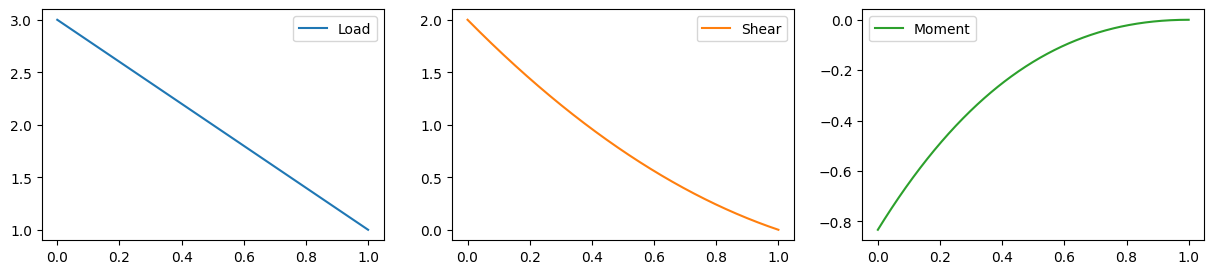

In [5]:
results.plot(subplots=True,layout=[1,3],figsize=[15,3]);

Notice the y-axis values, as they will change to adjust to the data.  We can see that both the shear and moment are 0 at the end of the beam.  The total load on the beam is $2~N$, and the shear at the base is $2~N$, since the support is holding up that entire load.  So it looks like the code worked!

<br>

Test the code with another problem by putting in the conditions of the cantilevered beam in lecture "1.2 Load Distribution Diagrams Example" and checking that the results match the answer there (all you need to do is change the values for `slope`,`init`,and `L` in the first code cell.  You can put whatever values you'd like for $w_0$ and $L$, since they are undefined in the problem).

### Exercise 1

It's a little more complicated to deal with point loads.  But if we check at every step in the loop to find if there is a point load, we can do it.  Let's try to simulate this example:

<br>

<img src = https://github.com/AugustanaPEA/ENGR_311/raw/main/Images/point_load_example.PNG width = 500>

<br>

We'll start by adding to our parameters: we'll store any point results in a Series called `points`.  Our point loads here are a 200 and 100 lb. load at both the midpoint ($x=5.0$ ft) and the end ($x=9.9$ ft) of the $10 ~ft$ beam.  The slope of the load change is $5.0~lb/ft~per~ft$:

In [15]:
L = 10.0          # in ft
init = 10.0       # in lb/ft
slope = 5.0       # in lb/ft per ft
points = pd.Series(index=[5.0,9.9], data=[200.0,100.0])
steps = 1001
delta = L/(steps-1)
x_array = np.linspace(L,0,steps)

Now we need a way to add the effect of these point loads.  The function below takes the load data created by `linear_load()`, and adds to it any point loads.  Notice that the point loads get divided by `delta` in the function: this is because they will later be multiplied by `delta` when we calculate shear:

In [16]:
def point_loads(x_array,points,delta,results):
    # Loop through every "step" in the x-direction
    for i in range(len(x_array)-1):
        # Check to see if there is a point load in this step
        for p in points.index:
            if p <= x_array[i] and p > x_array[i+1]:
                # Add the point load to the load function
                # 'Load_image' is added here as fourth element in the DataFrame
                # to make our plots more readable later on...
                results.iloc[i] = [results.Load.iloc[i] + points[p]/delta,0,0,
                                 results.Load_image.iloc[i] + points[p]]
    return results

Now we can create our load function using both `linear_load()` and `point_loads()`.  Once we've done that, we can calculate shear and moment just as we did above (`Load_image` is added just to make our plots more readable when we're done):

In [17]:
# Set up the DataFrame with initial values
results = pd.DataFrame(index=x_array, columns=['Load','Shear','Moment','Load_image'], dtype=object)
results.Load = linear_load(slope,init,x_array)
results.Load_image = linear_load(slope,init,x_array)
results.Shear = 0.0
results.Moment = 0.0
results = point_loads(x_array,points, delta,results)
V = 0
M = 0
results.iloc[0] = [results.Load.iloc[0],V,M,results.Load_image.iloc[0]]

# Loop through the steps and integrate the load and shear
for i in range(len(x_array)-1):
    V = V + (results.Load.iloc[i]+results.Load.iloc[i+1])/2.0 * delta
    results.iloc[i+1] = [results.Load.iloc[i+1],V,0,results.Load_image.iloc[i+1]]
    M = M - (results.Shear.iloc[i]+results.Shear.iloc[i+1])/2.0 * delta
    results.iloc[i+1] = [results.Load.iloc[i+1],V,M,results.Load_image.iloc[i+1]]

And now we'll plot our results.  We're using `pyplot` here rather than our usual `plot` because it is more versatile: it allows us to plot just 3 of the 4 parts of the DataFrame on the same plot:

Text(0.5, 0, 'Moment')

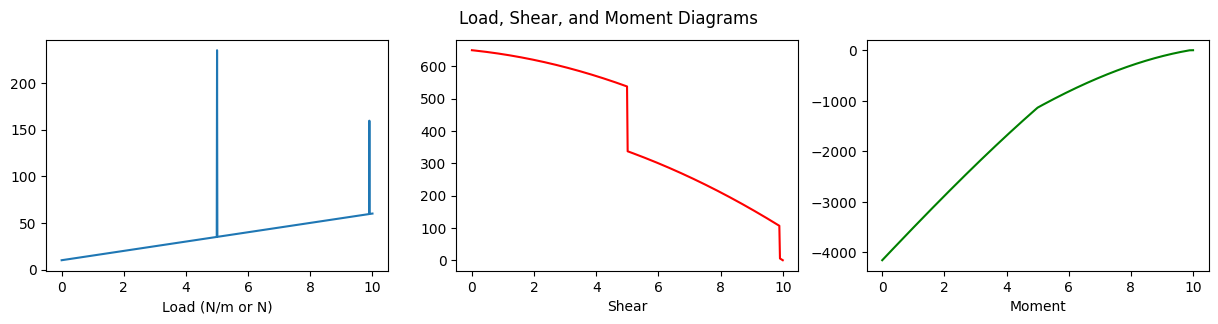

In [18]:
# Plot the load, shear, and moment diagrams
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
axs[0].plot(results.Load_image)
axs[1].plot(results.Shear, color='red')
axs[2].plot(results.Moment.index, results.Moment, color='green')
fig.suptitle('Load, Shear, and Moment Diagrams');
axs[0].set_xlabel('Length (m)')
axs[1].set_xlabel('Length (m)')
axs[2].set_xlabel('Length (m)')
axs[0].set_xlabel('Load (N/m or N)')
axs[1].set_xlabel('Shear')
axs[2].set_xlabel('Moment')

✅ ✅  Question 1:  Explain in your own words why the shear diagram jumps suddenly at $x=0.5$ m.  Why does the point load increase the shear so drastically?

✅ ✅ Answer A here.

✅ ✅ Question 2:  To find the change in shear $\Delta V$, we need to integrate the load over a given distance.   But if we integrate the load plot (on the left), we get positive numbers, suggesting that the shear $V$ should increase as we move left to right.  But the shear diagram values are going down (middle plot).  Explain this (seeming) problem.

✅ ✅ Answer B here.

### Exercise 2

Add the necessary parameters to the code in exercise 1 to confirm your answer to HW question 1.8 (and leave these plots when you turn the HW in).   *Notice: You can simply change the parameter values in the first cell of exercise 1.  You do not need to copy any code into the cells below this one*.

<br>

<img src = https://github.com/AugustanaPEA/ENGR_311/raw/main/Images/cantilever_HW_problem.PNG width = 400>

✅ ✅ Question C:  Will a cantilevered beam always have a negative moment?  Why or why not?

✅ ✅ Answer C here.